In [1]:
# Related Langchain imports:
import os, getpass, json, time, hashlib, random, re
from datetime import datetime, timedelta
from unittest.mock import patch, MagicMock

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langchain_core.documents import Document

from pydantic import BaseModel, Field
from langchain_core.tools import StructuredTool

from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

from operator import itemgetter
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

# Related LangGraph imports:
import uuid
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from typing import TypedDict, Dict, List, Tuple, Annotated, Literal, Optional
from IPython.display import Image, display

In [2]:
os.environ["METISAI_API_KEY"] = getpass.getpass("Enter your api key: ")
METISAI_API_KEY = os.environ["METISAI_API_KEY"]

### 1.2. Defining helper functions for LLMS & chains:

In [3]:
def get_llm_parser(model: str, temperature: float = 0.0):
    try:
        llm = ChatOpenAI(
            base_url="https://api.metisai.ir/openai/v1",
            api_key=METISAI_API_KEY,
            model_name=model,
            temperature=temperature,
        )
        llm_parser = llm | StrOutputParser()
        return llm_parser
    except Exception as e:
        print(f"Error!: API calling faild with {e}.\n Falling back to alternative.")

In [4]:
def get_raw_llm(model_name: str, temperature: float = 0.0):
    try:
        return ChatOpenAI(
            base_url="https://api.metisai.ir/openai/v1",
            api_key=METISAI_API_KEY,
            model_name=model_name,
            temperature=temperature
        )
    except Exception as e:
        print(f"Error!: API calling faild with {e}.\n Falling back to alternative.")

In [5]:
def node_agent_chain(system_message):
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_message, ),
            ("user", "{query}"),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    chain = prompt | get_llm_parser("gpt-4o")
    return chain

### 2. Defining nodes:

#### Node 1: The Triage Againt

In [6]:
class TriageCategoryOutput(BaseModel):
    """
    Structured output for triage_agent classification.
    The field contains a JSON string like: {"category": "BILLING"}
    """
    category_json: str = Field(..., description="Valid JSON string: {'category': 'BILLING'} OR {'category': 'TECHNICAL'} OR {'category': 'GENERAL'}")

prompt = ChatPromptTemplate.from_messages([
    ("system", """
        Just classify the topic of the following query: {query} into one of these three categories:
        ['BILLING', 'TECHNICAL', 'GENERAL'] with just one category without any explanation.
        
        You are a strict classifier. Classify this Persian/English query into EXACTLY ONE category: BILLING, TECHNICAL, GENERAL.

        Rules:
        - Return ONLY valid JSON object. No other text, no explanation, no markdown.
        - The JSON must have exactly one key: "category"
        - Value of "category" must be one of: "BILLING", "TECHNICAL", "GENERAL"
        - Do NOT add reason, confidence or any extra fields unless explicitly asked.

        User query: {query}

        ### Billing Examples:
        1. "My ID is 6788 but my subscription is not working" → {{"category": "BILLING"}}
            Reason: "Subscription" + "ID" = Financial Issue
        2. "How do I renew my subscription?" → {{"category": "BILLING"}}
            Reason: "Subscription" + "Renew" = Financial Transaction
        3. "My payment didn't go through" → {{"category": "BILLING"}}
            Reason: "Payment" = Financial Issue
        4. "How much does an annual subscription cost?" → {{"category": "BILLING"}}
            Reason: "Price" + "Subscription" = Financial Question
        
        ### Technical Examples:
        1. "How do I change my password?" → {{"category": "Technical"}}
            Reason: "Password" + "Replace" = Technical specific
        2. "Login page not showing" → {{"category": "TECHNICAL"}}
            Reason: "Login page" + "Show" = Technical issue
        3. "I get a 500 error" → {{"category": "TECHNICAL"}}
            Reason: "Error" = Technical system issue
        4. "Site not showing in my browser" → {{"category": "TECHNICAL"}}
            Reason: "Browser" + "Site" = Technical issue

        ### General examples:
        1. "Hello, how are you?" → {{"category": "GENERAL"}}
            Reason: Greetings
        2. "What are the company's business hours?" → {{"category": "GENERAL"}}
            Reason: General Question
        3. "Thanks for your help" → {{"category": "GENERAL"}}
            Reason: Thanks
        4. "I wanted general guidance" → {{"category": "GENERAL"}}
            Reason: General Request
        
        Response format (must be exactly this structure):
        {{"category": "BILLING"}}   OR   {{"category": "TECHNICAL"}}   OR   {{"category": "GENERAL"}}
    """),
    MessagesPlaceholder(variable_name="messages")]
)

llm = get_raw_llm('gpt-4o')

triage_chain = prompt | llm.with_structured_output(TriageCategoryOutput)

In [7]:
general_system_msg = """
    You are a general support assistant. Your job is to answer general questions from users, such as:
    - Greetings and greetings.
    - General questions about the company, products (without technical or financial details).
    - General pricing, policies, or basic tips.
    - If the question is related to technical support (bug, error) or financial (payment, subscription), say that it will be referred to the appropriate specialist.

    Response rules:
    - Keep answers short, polite, and helpful.
    - If necessary, ask more questions or guide the user.
    - Use Persian, unless the user speaks English.
    - Use conversation history to maintain context.

    Example:
    User: Hello, how are you?
    Response: Hello! I'm fine, thank you. How can I help?
"""

general_chain = node_agent_chain(general_system_msg)

In [8]:
def triage_agent(state):
    """Receiving the user's message and classifies it into one of three categories: BILLING, TECHNICAL, or GENERAL."""
    messages = state.get("messages", [])
    if not messages or not hasattr(messages[-1], "content"):
        warning_msg = "لطفا پیام خالی وارد نکنید!"
        print(f"⚠️ Warning: {[warning_msg]}")
        state["messages"].append(AIMessage(content=warning_msg))
        state["department"] = "Triage"
        state["next_step"] = "go_to_sentiment_guardrail"
        return state
    
    user_message = messages[-1].content
    print(f"🎯Triage:\n👤 user_message is: {user_message}")
    
    try:
        output = triage_chain.invoke({"query": user_message, "messages": messages})
        parsed = json.loads(output.category_json)
        category = parsed.get("category")
        if category not in {"BILLING", "TECHNICAL", "GENERAL"}:
            category = "GENERAL"
    
    except Exception as e:
        print(f"❌ خطا در پارس خروجی تریاژ: {e}")
        state["department"] = "Triage"
        state["next_step"] = "go_to_sentiment_guardrail"
        return state    
    
    if category == "GENERAL":
        try:
            general_response = general_chain.invoke({
                "messages": messages,
                "query": user_message
            })
            response_content = general_response if isinstance(general_response, str) else str(general_response)
            
            print(f"🤖 Response: {response_content}")
            state["messages"].append(AIMessage(content=response_content))
            state["department"] = "Triage"
            state["next_step"] = "go_to_sentiment_guardrail"
            return state
        
        except Exception as e:
            print(f"❌ در دریافت پاسخ عمومی: {e}")
            error_msg = AIMessage(content="پاسخ عمومی: لطفاً سؤال خود را واضح‌تر بیان کنید.")
            print(f"❌ خطا: {error_msg}")
            state["messages"].append(error_msg)
            state["department"] = "Triage"
            state["next_step"] = "go_to_sentiment_guardrail"
            return state
    
    else:
        print(f"Department: {category}")
        state["department"] = category
        state["next_step"] = 'go_to_billing_specialist' if category == "BILLING" else "go_to_technical_support"
        return state

#### Node 2: Billing Specialist

In [9]:
CSS_DB: Dict[str, dict] = {}

def init_CSS_DB():
    """Initializing the Unified Database."""
    
    base_date = datetime.now()
    
    integrated_users = [
        {
            "user_id": "67890",
            "username": "user_premium_001",
            "email": "premium.user@example.com",
            "registration_date": (base_date - timedelta(days=60)).isoformat(),
            
            "subscription": {
                "status": "active",
                "plan": "premium",
                "expiry_date": (base_date + timedelta(days=30)).isoformat(),
                "payment_method": "credit_card",
                "auto_renew": True
            },
            
            "transactions": [
                {
                    "transaction_id": "TRX-10020001",
                    "type": "subscription_payment",
                    "amount": 299000,
                    "currency": "IRR",
                    "status": "completed",
                    "date": (base_date - timedelta(days=15)).isoformat(),
                    "refundable": True,
                    "refund_deadline": (base_date + timedelta(days=15)).isoformat(),
                    "refund_status": "not_requested"
                },
                {
                    "transaction_id": "TRX-10010001",
                    "type": "initial_payment",
                    "amount": 299000,
                    "currency": "IRR",
                    "status": "completed",
                    "date": (base_date - timedelta(days=45)).isoformat(),
                    "refundable": False,
                    "refund_deadline": (base_date - timedelta(days=15)).isoformat(),
                    "refund_status": "expired"
                }
            ]
        },
        {
            "user_id": "24680",
            "username": "user_basic_002",
            "email": "basic.user@example.com",
            "registration_date": (base_date - timedelta(days=90)).isoformat(),
            
            "subscription": {
                "status": "active",
                "plan": "basic",
                "expiry_date": (base_date + timedelta(days=5)).isoformat(),
                "payment_method": "wallet",
                "auto_renew": False
            },
            
            "transactions": [
                {
                    "transaction_id": "TRX-10020002",
                    "type": "subscription_payment",
                    "amount": 99000,
                    "currency": "IRR",
                    "status": "completed",
                    "date": (base_date - timedelta(days=25)).isoformat(),
                    "refundable": False,
                    "refund_deadline": (base_date - timedelta(days=5)).isoformat(),
                    "refund_status": "expired"
                }
            ]
        },
        {
            "user_id": "12345",
            "username": "user_expired_003",
            "email": "expired.user@example.com",
            "registration_date": (base_date - timedelta(days=120)).isoformat(),
            
            "subscription": {
                "status": "expired",
                "plan": "premium",
                "expiry_date": (base_date - timedelta(days=10)).isoformat(),
                "payment_method": "credit_card",
                "auto_renew": True
            },
            
            "transactions": [
                {
                    "transaction_id": "TRX-10020003",
                    "type": "failed_payment",
                    "amount": 299000,
                    "currency": "IRR",
                    "status": "failed",
                    "date": (base_date - timedelta(days=40)).isoformat(),
                    "refundable": False,
                    "refund_deadline": None,
                    "refund_status": "not_applicable"
                }
            ]
        },
        {
            "user_id": "08642",
            "username": "user_cancelled_004",
            "email": "cancelled.user@example.com",
            "registration_date": (base_date - timedelta(days=180)).isoformat(),
            
            "subscription": {
                "status": "cancelled",
                "plan": "basic",
                "expiry_date": (base_date - timedelta(days=30)).isoformat(),
                "payment_method": "wallet",
                "auto_renew": False
            },
            
            "transactions": [
                {
                    "transaction_id": "TRX-10020004",
                    "type": "refunded_payment",
                    "amount": 99000,
                    "currency": "IRR",
                    "status": "refunded",
                    "date": (base_date - timedelta(days=60)).isoformat(),
                    "refundable": False,
                    "refund_deadline": None,
                    "refund_status": "completed"
                }
            ]
        },
        {
            "user_id": "12357",
            "username": "user_trial_005",
            "email": "trial.user@example.com",
            "registration_date": (base_date - timedelta(days=5)).isoformat(),
            
            "subscription": {
                "status": "trial",
                "plan": "trial",
                "expiry_date": (base_date + timedelta(days=2)).isoformat(),
                "payment_method": "none",
                "auto_renew": False
            },
            
            "transactions": [
                {
                    "transaction_id": "TRX-10020005",
                    "type": "trial_registration",
                    "amount": 0,
                    "currency": "IRR",
                    "status": "completed",
                    "date": (base_date - timedelta(days=2)).isoformat(),
                    "refundable": False,
                    "refund_deadline": None,
                    "refund_status": "not_applicable"
                }
            ]
        }
    ]
    
    for user in integrated_users:
        CSS_DB[user["user_id"]] = user
        CSS_DB[user["username"]] = user

init_CSS_DB()

In [10]:
def check_subscription_status(user_id: str) -> str:
    """Checking user subscription status from integrated database."""
    try:
        if not user_id:
            return "❌ شناسه کاربر نامعتبر است."
        
        user_id = str(user_id).strip()
        user_data = CSS_DB.get(user_id)
        
        if not user_data:
            for key, user in CSS_DB.items():
                if isinstance(user, dict) and user.get("username") == user_id:
                    user_data = user
                    break
        
        if not user_data:
            hash_val = int(hashlib.md5(user_id.encode()).hexdigest(), 16)
            if hash_val % 5 == 0:
                return "✅ اشتراک شما فعال است (طرح پایه، ۱۵ روز باقی‌مانده)."
            elif hash_val % 5 == 1:
                return "⚠️ اشتراک شما در آستانه انقضا است (۳ روز باقی‌مانده)."
            elif hash_val % 5 == 2:
                return "❌ اشتراک شما منقضی شده است (۵ روز گذشته)."
            elif hash_val % 5 == 3:
                return "🎯 شما در دوره آزمایشی رایگان هستید (۷ روز باقی‌مانده)."
            else:
                return "⏸️ اشتراک شما به حالت تعلیق درآمده است."
        
        sub = user_data["subscription"]
        expiry_date = datetime.fromisoformat(sub["expiry_date"])
        days_remaining = (expiry_date - datetime.now()).days
        
        if sub["status"] == "active" and days_remaining > 0:
            return (
                f"✅ اشتراک شما فعال است.\n"
                f"• طرح: {sub['plan']}\n"
                f"• روزهای باقی‌مانده: {days_remaining} روز\n"
                f"• تاریخ انقضا: {expiry_date.strftime('%Y-%m-%d')}\n"
                f"• روش پرداخت: {sub['payment_method']}\n"
                f"• تمدید خودکار: {'بله' if sub['auto_renew'] else 'خیر'}"
            )
        elif sub["status"] == "expired":
            return f"❌ اشتراک شما منقضی شده است (از {abs(days_remaining)} روز پیش)."
        elif sub["status"] == "cancelled":
            return f"⏸️ اشتراک شما لغو شده است."
        elif sub["status"] == "trial":
            return f"🎯 شما در دوره آزمایشی هستید ({days_remaining} روز باقی‌مانده)."
        
    except Exception as e:
        print(f"⚠️ خطا در بررسی اشتراک: {e}")
    return "⚠️ خطایی در بررسی وضعیت اشتراک رخ داد."

In [11]:
def find_transaction(transaction_id: str) -> Optional[dict]:
    """Finding a transaction in a unified database"""
    transaction_id = transaction_id.strip().upper()
    
    # Searchin for find users' transaction_ID:
    for user_id, user_data in CSS_DB.items():
        if isinstance(user_data, dict) and "transactions" in user_data:
            for tx in user_data["transactions"]:
                if tx["transaction_id"] == transaction_id:
                    return {"transaction": tx, "user": user_data}
    
    return None

In [12]:
def process_refund(transaction_id: str) -> Tuple[bool, str]:
    """
    Processing a refund using a mock to simulate the payment system

    Args:
    transaction_id: Transaction ID (format: TRX-XXXXXXX)

    Returns:
    (success: bool, message: str): Operation result and explanatory message
    """
    try:
        if not transaction_id or not isinstance(transaction_id, str):
            return False, "❌ شناسه تراکنش نامعتبر است."
        
        transaction_id = transaction_id.strip().upper()
        
        result = find_transaction(transaction_id)
        
        if not result:
            return False, f"❌ تراکنش {transaction_id} در سیستم پرداخت یافت نشد."
        
        tx = result["transaction"]
        user = result["user"]
        
        if tx["refund_status"] == "completed":
            return True, f"✅ بازگشت وجه این تراکنش قبلاً انجام شده است.\nمبلغ: {tx['amount']:,} ریال"
        
        elif tx["refund_status"] == "expired":
            return False, "❌ مهلت قانونی بازگشت وجه گذشته است (۳۰ روز از تاریخ تراکنش)."
        
        elif tx["status"] == "failed":
            return False, "❌ این تراکنش ناموفق بوده و نیازی به بازگشت وجه ندارد."
        
        elif tx["amount"] == 0:
            return True, "ℹ️ این تراکنش رایگان بوده و بازگشت وجهی ندارد."
        
        # Simulate Payment API Call with Mock
        # ------------------------------------------------------------
        # Here we use mock to simulate real API
        # ------------------------------------------------------------
        # Mock to simulate payment gateway API
        with patch('requests.post') as mock_post:
            mock_response = MagicMock()
            mock_response.status_code = 200
            mock_response.json.return_value = {
                "success": True,
                "refund_id": f"REF-{hashlib.md5(transaction_id.encode()).hexdigest()[:8].upper()}",
                "processing_time": "3-5 business days",
                "timestamp": datetime.now().isoformat()
            }
            mock_post.return_value = mock_response
            mock_post.side_effect = lambda *args, **kwargs: (
                print(f"🔗 در حال ارسال درخواست بازگشت وجه برای {transaction_id}..."),
                mock_response
            )[1]
            
            response = mock_post(
                "https://api.payment-gateway.com/v1/refunds",
                json={
                    "transaction_id": transaction_id,
                    "amount": tx["amount"],
                    "currency": tx["currency"],
                    "reason": "customer_request"
                }
            )
            
            if response.status_code == 200:
                refund_data = response.json()
                
                tx["refund_status"] = "completed"
                tx["refund_completion_date"] = datetime.now().isoformat()
                tx["refund_reference"] = refund_data["refund_id"]
                
                if tx["type"] == "subscription_payment":
                    user["subscription"]["status"] = "cancelled"
                    user["subscription"]["cancellation_date"] = datetime.now().isoformat()
                
                message = (
                    f"✅ درخواست بازگشت وجه با موفقیت ثبت شد!\n"
                    f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n"
                    f"• شناسه تراکنش: {transaction_id}\n"
                    f"• مبلغ بازگشتی: {tx['amount']:,} ریال\n"
                    f"• کاربر: {user['username']} ({user['user_id']})\n"
                    f"• شماره پیگیری: {refund_data['refund_id']}\n"
                    f"• زمان تخمینی واریز: {refund_data['processing_time']}\n"
                    f"• تاریخ درخواست: {datetime.now().strftime('%Y-%m-%d %H:%M')}\n"
                    f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n"
                    f"📧 برای پیگیری: payments@example.com | 📞 ۰۲۱-۱۲۳۴۵۶۷۸"
                )
                return True, message
            else:
                return False, "⚠️ درگاه پرداخت در حال حاضر پاسخگو نیست. لطفاً مجدداً تلاش کنید."
        
    except Exception as e:
        print(f"🔴 خطای سیستم بازگشت وجه: {type(e).__name__}: {e}")
        return False, (
            "⚠️ خطایی در سیستم پردازش بازگشت وجه رخ داد.\n"
            "لطفاً:\n"
            "۱. بعد از ۱۰ دقیقه مجدد تلاش کنید\n"
            "۲. با پشتیبانی مالی تماس بگیرید\n"
            "۳. از صحت شناسه تراکنش اطمینان حاصل کنید"
        )

In [13]:
# 1. check_subscription_tool:
class GetSubscriptionStatus(BaseModel):
    """Schema for checking a user's subscription status in the billing system."""
    user_id: str = Field(..., description="User's unique identifier (numeric user_id) to check subscription details")


check_subscription_tool = StructuredTool.from_function(
    func=check_subscription_status,
    name="check_subscription_status",
    description="Checks user's subscription status including plan type, expiry date, payment method, and auto-renewal settings.",
    args_schema=GetSubscriptionStatus
)

# process_refund_tool:
class GetRefund(BaseModel):
    """Schema for processing a refund request for a financial transaction."""
    transaction_id: str = Field(..., description="Transaction ID (format: TRX-XXXXXXX) to process refund for")


process_refund_tool = StructuredTool.from_function(
    func=process_refund,
    name="process_refund",
    description="Processes refund requests for financial transactions. Checks eligibility, processes payment reversal, and updates transaction status.",
    args_schema=GetRefund
)

class BillingSpecialistOutpotFormat(BaseModel):
    """
    Structured output for triage_agent classification.
    The field contains a JSON string like: {"category": "BILLING"}
    """
    Irrelevant_query: str = Field(..., description="Specifies if the query is irrelevant or a technical question that should be returned to triage. Possible values are [yes, no].")
    result: str = Field(..., description="Return of specialized answers related to finance")


In [14]:
def extract_user_id_from_query(query: str) -> Optional[str]:
    """
    Extract user_id from user message.

    Supported patterns:
    - 4-6 digit numbers
    - Prefixed with: user/user_id
    - In quotes, parentheses or after a colon
    """
    
    if not query:
        return None
    
    # Regex pattern:
    pattern = r'(?:کاربر|کاربری|آی[\.\s]*دی|شناسه|یوزر|user|id|userid)[\s:]*(\d{4,6})|["\'\(](\d{4,6})["\'\)]|\b(\d{4,6})\b'
    
    match = re.search(pattern, query, re.IGNORECASE)
    
    if match:
        for group in match.groups():
            if group:
                return group
    
    return None

In [15]:
def extract_transaction_id_from_query(query: str) -> Optional[str]:
    """
    Extract transaction_id from user message.

    Supported formats:
    - TRX-12345678
    - TXN-12345678
    - REF-12345678
    - TRANSACTION-12345678
    - 12-34567890 (Bank Tracking Number)
    - Any 8-12 digit number
    """
    
    if not query:
        return None
    
    query_upper = query.upper()
    
    # Regex pattern:
    pattern = r'(?:TRX|TXN|REF|TRANSACTION|شماره تراکنش|کد تراکنش|شناسه پرداخت)[\s\-_:]*(\d{8,12})|\b(\d{8,12})\b'
    
    match = re.search(pattern, query_upper, re.IGNORECASE)
    
    if match:
        numbers = None
        for group in match.groups():
            if group:
                numbers = group
                break
        
        if numbers:
            numbers = numbers.lstrip('0')
            
            if len(numbers) < 8:
                numbers = numbers.zfill(8)
            
            numbers = numbers[:8]
            
            if 'TRX-' in query_upper or 'TRANSACTION-' in query_upper:
                return f"TRX-{numbers}"
            elif 'TXN-' in query_upper:
                return f"TXN-{numbers}"
            elif 'REF-' in query_upper:
                return f"REF-{numbers}"
            else:
                return f"TRX-{numbers}"
    
    return None

In [16]:
billing_system_msg = """
# 1. Identity:
You are an expert financial support specialist with 10+ years of experience in subscription management and payment processing. 
You are authorized to handle billing inquiries, subscription status checks, and refund requests.

# 2. Objective:
Your task is to analyze user queries and determine whether to use:
1. check_subscription_status tool - for subscription-related inquiries
2. process_refund tool - for refund and transaction-related requests
3. If none of these apply, provide a helpful answer. Also, if the user query is related to technical questions, or you receive an unrelated question, you should return the request to triage.

# 3. Step-by-Step Decision Process:
Follow these steps for every user query:

Step 1: Analyze the query
- Identify keywords related to: subscription, payment, refund, transaction, billing
- Check if user_id is provided: {user_id}
- Check if transaction_id is provided: {transaction_id}

Step 2: Determine the appropriate tool
- If query contains: "subscription", "membership", "plan", "renewal", "expiry", "status", "account" → Use check_subscription_status
- If query contains: "refund", "return money", "cancel payment", "transaction", "TRX", "TXN" → Use process_refund
- If query is unclear or mixed: Ask for clarification

Step 3: Prepare tool arguments
- For check_subscription_status: Use user_id = {user_id}
- For process_refund: Use transaction_id = {transaction_id} (if available)

Step 4: Handle missing information
- If user_id is "unknown" for subscription queries: Ask "Please provide your user ID"
- If transaction_id is None for refund queries: Ask "Please provide your transaction ID (e.g., TRX-12345678)"

# 4. Reference Examples:
Example 1 (Subscription):
User: "What's my subscription status?"
Available: user_id = "67890", transaction_id = None
Action: Use check_subscription_status with user_id="67890"
Response: "Your premium subscription is active, expires in 30 days."

Example 2 (Refund):
User: "I want refund for transaction TRX-10020001"
Available: user_id = "67890", transaction_id = "TRX-10020001"
Action: Use process_refund with transaction_id="TRX-10020001"
Response: "Refund processed successfully. Amount: 299,000 IRR"

Example 3 (Missing info):
User: "I need a refund"
Available: user_id = "67890", transaction_id = None
Action: Ask for transaction ID
Response: "Please provide your transaction ID (e.g., TRX-12345678)"

Example 4 (Technical query):
User: "How to reset my password?"
Available: user_id = "67890", transaction_id = None
Action: Not a billing query
Response: "This appears to be a technical question. Please contact technical support."

# 5. Output Format:
- If using a tool: Make a single tool call with correct arguments
- If asking for clarification: Be specific about what information is needed
- If redirecting to technical support: Provide clear guidance
- Always respond in Persian unless user asks for English
- Keep responses concise but complete

# Current information:
- User Query: {query}
- User ID Available: {user_id}
- Transaction ID Available: {transaction_id}

# Final Financial Expert Answer:
"""

AIMessages_extention_lst = []

In [17]:
def billing_specialist(state):
    """Responsible for handling user financial questions and requests, including subscription reviews, payments, and refunds."""
    print("💰 Billing specialist: ")
    messages = state.get("messages", [])
    if not messages:
        warning_msg=AIMessage(content="⚠️ هیچ پیامی برای پردازش وجود ندارد.")
        state["messages"].append([warning_msg])
        state["next_step"] = "to_go_sentiment_guardrail"
        return state
    try:
        query = messages[-1].content
        extrected_trans_id = extract_transaction_id_from_query(query)
        
        user_id = state['user_id'] if extract_user_id_from_query(query) else state['user_id']
        transaction_id = extrected_trans_id if extrected_trans_id else ""

        llm = get_raw_llm("gpt-4o")

        prompt = ChatPromptTemplate.from_messages(
            [
                ("system", billing_system_msg, ),
                MessagesPlaceholder(variable_name="messages"),
            ]
        )
        
        llm_with_tools = llm.bind_tools([check_subscription_tool, process_refund_tool], tool_choice="auto")
        
        # structured_llm_with_tools = llm_with_tools.with_structured_output(BillingSpecialistOutpotFormat)
        technical_support_chain = prompt | llm_with_tools
        
        if state['user_id']:
            print(f"User ID from state: {state['user_id']}")
        
        response = technical_support_chain.invoke({
            "messages": messages,
            "query": query,
            "user_id": user_id if user_id else "unknown",
            "transaction_id": transaction_id if transaction_id else "None"
        })
        
        if len(response.content) != 0:
            # print(f"🤖 Response: {AIMessage(content=response.content)}")
            AIMessages_extention_lst.append(AIMessage(content=response.content))
        
        # Tool calls:
        if hasattr(response, 'tool_calls') and response.tool_calls:
            tool_call = response.tool_calls[0]
            if tool_call["name"] == "check_subscription_status":
                if user_id and user_id != "unknown":
                    tool_args = {"user_id": user_id}
                else:
                    tool_args = tool_call["args"]
                
                tool_result = check_subscription_tool.invoke(tool_args)
                
                tool_result_msg = AIMessage(
                    content=str(tool_result),
                    tool_call_id=tool_call.get("id"),
                    name="check_subscription_status"
                )
                print(f"🤖 Response: {[tool_result_msg]}")
                state["messages"].append(tool_result_msg)
                
            elif tool_call["name"] == "process_refund":
                if transaction_id and transaction_id != "":
                    tool_args = {"transaction_id": transaction_id}
                else:
                    tool_args = tool_call["args"]
                
                tool_result = process_refund_tool.invoke(tool_args)
                
                tool_result_msg = AIMessage(
                    content=str(tool_result),
                    tool_call_id=tool_call.get("id"),
                    name="process_refund"
                )
                print(f"🤖 Response: {[tool_result_msg]}")
                state["messages"].append(tool_result_msg)
                
        else:
            response_text = response.content if hasattr(response, 'content') else str(response)
            irrelevant_keywords = ["فنی", "تکنیکال", "پشتیبانی فنی", "خطا", "باگ", "ایراد"]
            if any(keyword in response_text for keyword in irrelevant_keywords):
                llm_result_msg = AIMessage(content=response_text)
                print("⚠️ سوال نامربوط تشخیص داده شد. برگشت به تریاژ")
                print(f"🤖 Response: {[llm_result_msg]}")
                state["messages"].append(llm_result_msg)
                state["next_step"] = "back_to_triage_agent"
                return state
        
    except Exception as e:
        print(f"❌ خطا: {e}")
        error_msg = AIMessage(
            content="🤖 متأسفانه در پردازش درخواست مالی شما مشکلی پیش آمد."
        )
        state["messages"].append(error_msg)
    
    state["next_step"] = "to_go_sentiment_guardrail"
    return state

#### Node 3: Technical Support

In [18]:
tool_technical_system_msg = """
# 1. Identity
You are a senior technical support specialist with years of experience troubleshooting software systems. You have valid credentials in the fields of IT and systems management.

# 2. Objective
Your objective: To provide accurate and practical answers to users' technical problems based only on available technical documentation

# 3. Step-by-Step Instructions
To answer each question, follow these steps:

Step 1: Analyze the user's question
- Read the question carefully
- Identify the problem area (authentication, payment, system performance, ...)

Step 2: Search the documentation
- Only use information in {context}
- Don't guess if the answer isn't in the documentation
- Never make up new facts

Step 3: Structure the answer
- If the problem is identified: Provide a step-by-step solution
- If you do not know the answer, just say "I don't know"

Step 4: Quality Control
- Check the answer for technical accuracy
- Avoid using information out of {context}

# 4. Reference Examples
Example 1:
User question: "How do I reset my password?"
Context content: "To reset your password, go to the login page and click the Forgot Password link..."
Correct answer: "To reset your password, follow these steps:
1. Go to the login page
2. Click 'Forgot Password'
3. Enter your email"

Example 2:
User question: "Why is my system slow?"
Context content: "There is no information about system performance"
Correct answer: "Sorry, I couldn't find any information about the system slowness issue in the technical documentation. Please provide more details."

Example 3:
User question: "How can I receive an invoice?"
Context content: "Invoices are issued by the finance department"
Correct answer: "This question is related to the finance department. Please contact the billing department."

# 5. Output Format
- The answer should be clear in Persian
- If there is a solution, provide it numerically and step by step
- If there is not enough information, state it honestly
- The answer should be between 50 and 200 words

# Technical Documentation Information
{context}

# User Question
{query}

# Final Technical Expert Answer:
"""

In [19]:
text_path = "tech_doc.txt"
loader = TextLoader(text_path, encoding="utf-8")
documents = loader.load()

# documents = Document(
#     page_content=documents,
#     metadata={"source": "دانشنامه کیهان‌شناسی", "topic": "کوازارها", "language": "fa"}
# )

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=102,
    # separators=["\n\n", "\n", " ", ""]
)
chunks = text_splitter.split_documents(documents)

# Define vectorstore & retriever:
hf_embedding = HuggingFaceEmbeddings(
    model_name="HooshvareLab/bert-base-parsbert-uncased",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': False}
)

vectorstore = FAISS.from_documents(chunks, hf_embedding)

No sentence-transformers model found with name HooshvareLab/bert-base-parsbert-uncased. Creating a new one with mean pooling.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: HooshvareLab/bert-base-parsbert-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [20]:
def search_knowledge_base(query):
    """Searching the technical knowledge base using RAG to answer technical support questions."""
    try:
        retriever = vectorstore.as_retriever(
            search_kwargs={"k": 3}
        )

        # Defining RAG, prompt, llm and then chain:
        RAG_chain = RunnableParallel(
            {
                "context": itemgetter("query") | retriever,
                "query": RunnablePassthrough(),
            }
        )

        prompt = ChatPromptTemplate.from_messages(
            [
                ("system", tool_technical_system_msg),
                ("user", "{query}"),
                # MessagesPlaceholder(variable_name="messages"),
            ]
        )

        llm = get_llm_parser("gpt-4o", temperature=0)

        chain = RAG_chain | prompt | llm
        response = chain.invoke({"query": query})
        return response
    except Exception as e:
        print(f"⚠️ خطا در جستجوی دانش پایه: {e}")
        return "⚠️ خطایی در سیستم جستجو رخ داد. لطفاً بعداً تلاش کنید."


In [21]:
class GetSearchKnowledgeBase(BaseModel):
    """Schema for technical support question input to search knowledge base."""
    query: str = Field(..., description="User's technical question or problem to search in the technical knowledge base of the support system")


search_knowledge_tool = StructuredTool.from_function(
    func=search_knowledge_base,
    name="search_knowledge_base",
    description="Search in technical knowledge base for customer support issues like password reset, login problems, errors, account settings, etc.",
    args_schema=GetSearchKnowledgeBase
)


In [22]:
node_technical_system_msg = """
    You are a general support assistant. Your job is to answer general questions from users, such as:
    - Greetings and greetings.
    - General questions about the company, products (without technical or financial details).
    - General pricing, policies, or basic tips.
    - If the question is related to technical support (bug, error) or financial (payment, subscription), say that it will be referred to the appropriate specialist.

    Response rules:
    - Keep answers short, polite, and helpful.
    - If necessary, ask more questions or guide the user.
    - Use Persian, unless the user speaks English.
    - Use conversation history to maintain context.

    Example:
    User: Hello, how are you?
    Response: Hello! I'm fine, thank you. How can I help?
"""

In [23]:
def technical_support(state):
    """Responsible for handling technical questions from users using the specialized support knowledge base."""
    print("🔧 Technical support: ")
    messages = state.get("messages", [])
    if not messages:
        warning_msg = AIMessage(content="⚠️ هیچ پیامی برای پردازش وجود ندارد.")
        state["messages"].append([warning_msg])
        state["next_step"] = "to_go_sentiment_guardrail"
        return state

    try:
        query = messages[-1].content

        llm = get_raw_llm("gpt-4o")

        prompt = ChatPromptTemplate.from_messages(
            [
                ("system", node_technical_system_msg, ),
                ("user", "{query}"),
                MessagesPlaceholder(variable_name="messages"),
            ]
        )
        
        technical_support_chain = prompt | llm.bind_tools([search_knowledge_tool], tool_choice={
            "type": "function", 
            "function": {"name": "search_knowledge_base"}
        })
        
        response = technical_support_chain.invoke({
            "messages": messages,
            "query": query
        })

        if hasattr(response, "tool_calls") and response.tool_calls:
            tool_call = response.tool_calls[0]
            
            if tool_call["name"] == "search_knowledge_base":
                tool_result = search_knowledge_tool.invoke(tool_call["args"])
                tool_result_msg = AIMessage(
                    content=str(tool_result),
                    tool_call_id=tool_call.get("id"),
                    name="search_knowledge_base"
                )
                print(f"🤖 Response: {[tool_result_msg]}")
                state["messages"].append(tool_result_msg)
            else:
                pass  
    except Exception as e:
        print(f"❌ خطا در اجرای ابزار: {e}")
        error_msg = AIMessage(
            content="🤖 متأسفانه در پردازش سؤال فنی شما مشکل پیش آمد. لطفاً دوباره تلاش کنید."
        )
        state["messages"].append([error_msg])
    
    state["next_step"] = "to_go_sentiment_guardrail"
    return state

#### Node 4: Sentiment Guardrail

In [24]:
def sentiment_guardrail(state):
    """Routing with the ability to stop for human intervention"""
    
    if state["next_step"] == "end_of_flow":
        print("5. Go to 'END' state, task is finished and skip sentiment analysis.")
        return state
    
    print("🛡️ Sentiment guardrail: ")
    messages = state["messages"]
    
    if messages:
        user_message = messages[-1].content if messages[-1].__class__.__name__ == "HumanMessage" else messages[-2].content
    
    print(f"1. 👤 user_message: {user_message}")
    
    if not user_message:
        state["sentiment"] = "neutral"
        return state
    
    prompt = f"""
    # Role and Identity:
    You are a specialist with 10 years of experience in the field of psycholinguistics and customer analytics.
    Your expertise lies in accurately detecting anger, frustration, and negative emotions in support conversations.

    #Analysis Goal:
    Your goal is to accurately analyze the user's tone and need to decide whether to intervene with a senior manager.
    The intelligent support system should only interrupt the flow (between agents) and involve the manager (human) if it detects real anger.

    # Analysis Guidelines:
    1. Consider the entire message, not just keywords
    2. Pay attention to context
    3. Distinguish between normal annoyance and dangerous anger
    4. Consider the following factors:
    - Use of harsh words and swear words
    - Repeated complaints
    - Direct or indirect threats
    - Request to speak to a manager
    - Expressing extreme frustration

    # Reference Examples:
    - "Your service is terrible, give me my money back!" → Negative
    - "Please help, I can't log into my account" → Neutral
    - "Thanks for your great support" → Positive
    - "I'm tired of these few issues I'm having trouble with" → Negative
    - "Is there a refund?" ← Neutral
    - "You're lying, you're a scam!" → Negative
    - "How can I renew my subscription?" ← Neutral

    # Output format:
    Return **and only** one of these three words without any modifiers:
    - "positive"
    - "neutral"
    - "negative"

    # User message for analysis
    Message: "{user_message}"

    # Final analysis (only one word):
    """
    
    llm = get_raw_llm("gpt-4-turbo-preview")
    
    try:
        response = llm.invoke(prompt)
        sentiment = response.content.strip().lower()
    
        if sentiment not in ["positive", "neutral", "negative"]:
            sentiment = "neutral"
    except:
        sentiment = "neutral"

    state["sentiment"] = sentiment
    print(f"2. Sentiment analysis 🎭: {sentiment}")
    
    if sentiment == "negative":
        print("3. Interrupting for human intervention...")
        interrupt({
            "sentiment": state["sentiment"],
        })
    
    if state['next_step'] == "go_to_sentiment_guardrail": # for general or empty user's messages
        print("5. Go to 'END' state, task is finished and skip sentiment analysis.")
        return state
    
    state['messages'] += AIMessages_extention_lst
    state["next_step"] = "end_of_flow"
    
    return state


## 2. Implementation and development stages:

### 1. Define Graph State Construction:

In [25]:
def route_from_triage(state) -> Literal["billing_specialist", "technical_support", "sentiment_guardrail"]:
    """Determining each node that must be returned based on department' type."""
    dept = state.get("department").capitalize()
    match dept: 
        case "Billing":
            return "billing_specialist"
        case "Technical":
            return "technical_support"
        case _:
            return "sentiment_guardrail"

In [26]:
class SupportState(TypedDict): 
    messages: List[BaseMessage] # Chat History
    user_id: str 
    sentiment: str       # "Positive", "Neutral", "Negative" 
    department: str      # "Billing", "Technical", "Triage" 
    next_step: str       # Control flow variable


graph = StateGraph(SupportState)

graph.add_node("triage_agent", triage_agent)
graph.add_node("billing_specialist", billing_specialist)
graph.add_node("technical_support", technical_support)
graph.add_node("sentiment_guardrail", sentiment_guardrail)

graph.add_edge(START, "triage_agent")
graph.add_conditional_edges("triage_agent", route_from_triage)
graph.add_conditional_edges("billing_specialist", 
                            lambda state: "triage_agent" if state["next_step"] == "back_to_triage_agent" else "sentiment_guardrail", 
                            {
                                "triage_agent": "triage_agent",
                                "sentiment_guardrail": "sentiment_guardrail"
                            }
                        )
graph.add_edge("technical_support", "sentiment_guardrail")
graph.add_edge("sentiment_guardrail", END)

checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer)

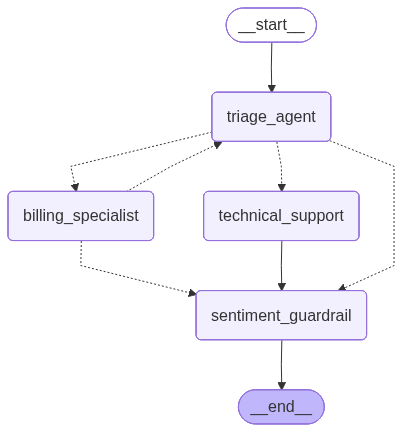

In [27]:
display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
def human_in_the_loop(thread_id: str, response: str = None):
    """The admin enters and enters a manual message."""
    
    if response is None:
        response = "👨‍💼 من مدیر ارشد هستم. عذرخواهی می‌کنم، مشکل شما را شخصاً پیگیری خواهم کرد."
    
    config = {"configurable": {"thread_id": thread_id}}
    
    try:
        snapshot = app.get_state(config)
        
        if snapshot and hasattr(snapshot, 'values'):
            current_messages = snapshot.values.get("messages", [])
        else:
            current_messages = []
        
        print(f"👨‍💼 Admin is feedback: {[HumanMessage(content=response)]}")
        updates = {
            "messages": current_messages + [HumanMessage(content=response)], # not AIMessage(content=response) --- IGNORE ---
            "next_step": "end_of_flow"   
        }
        app.update_state(config, updates)
        final_state = app.invoke(None, config)
        
        print("6. The admin responded and the system continued successfully. ✅")
        return final_state
        
    except Exception as e:
        print(f"6. Error ❌ in human_manager: {e}")

In [29]:
user_messagess = [
    "چطور میتونم رمز عبورم را ریست کنم؟", # 0 ok
    "پولم را دزدیدید! این سیستم به دردم نمی‌خورد! میخواهم با مدیر حرف بزنم.", # 1 ok
    "لینک بازنشانی رمز عبور چند ساعت اعتبار دارد؟", # 2 ok
    "پولم را پس بدهید. شناسه تراکنش: TRX-10020004!", # 3 ok
    "کاربر با آیدی وارد شده هستم - وضعیت حساب من را بگو", # 4 "user_id": "24680" ok
    "چرا نمی‌توانم وارد حساب کاربری‌ام شوم؟", # 5 ok
    "وضعیت اشتراک من چگونه است؟ آیدی من 08642 است", # 6 nok
    "اشتراک من کار نمی کند. آیدی من 12345 است.", # 7 ok
    "TRANSACTION-11223344 را refund کنید", # 8 ok
    
    "سرویس شما افتضاحه! پول منو پس بده!", # 9 ok
    "صفحه بازنشانی رمز عبور در کدام آدرس قرار دارد؟", # 10 ok
    "من از خدمات شما راضی هستم، ممنون!", # 11 ok
    "چطور می‌توانم بازپرداخت کنم؟ ", # 12 ok
    "از سیستم شما به هیچ وجه راضی نیستم! این کلاه‌برداری است!", #13 ok
    "سلام حال شما خوب است؟", # 14 ok
    "آیا برای کسب‌وکارها طرح خاصی دارید؟", # 15 ok
    "سیستم کند است، مشکل چیست؟", # 16 ok
    "خطای ۴۰۴ دریافت می‌کنم", # 17 ok
    "برای TRX-10020001 درخواست بازگشت وجه دارم", # 18 ok
]

# user_msg = random.choice(user_messagess)
# user_msg
user_msg = user_messagess[1]
user_msg

'پولم را دزدیدید! این سیستم به دردم نمی\u200cخورد! میخواهم با مدیر حرف بزنم.'

In [30]:
if __name__ == "__main__":
    initial_state = {
        "messages": [HumanMessage(content=user_msg)],
        "user_id": "", # "user_id": "24680" for user_message 4th
        "sentiment": "",
        "department": "Triage",
        "next_step": "",
    }
    
    thread_id = str(uuid.uuid4())
    config = {"configurable": {"thread_id": thread_id}}
    result = app.invoke(initial_state, config)

    try:
        if result is not None and "__interrupt__" in result:
            print("4. Graph interrupted ⏸️ for human intervention")
            # print("Interrupt payload:", result["__interrupt__"])
            
            # The senior manager enters:
            final_state = human_in_the_loop(thread_id, "من مدیر ارشد هستم. عذرخواهی می‌کنم، مشکل شما را شخصاً پیگیری خواهم کرد.")
        else:
            print("3. Graph ended without interruption")
            final_state = result

        print(f"***The final state***\n: {len(final_state)}: {final_state}")
    except Exception as e:
        print(f"Error during final state processing: {e}")


🎯Triage:
👤 user_message is: پولم را دزدیدید! این سیستم به دردم نمی‌خورد! میخواهم با مدیر حرف بزنم.
Department: BILLING
💰 Billing specialist: 
🛡️ Sentiment guardrail: 
1. 👤 user_message: پولم را دزدیدید! این سیستم به دردم نمی‌خورد! میخواهم با مدیر حرف بزنم.
2. Sentiment analysis 🎭: negative
3. Interrupting for human intervention...
4. Graph interrupted ⏸️ for human intervention
👨‍💼 Admin is feedback: [HumanMessage(content='من مدیر ارشد هستم. عذرخواهی می\u200cکنم، مشکل شما را شخصاً پیگیری خواهم کرد.', additional_kwargs={}, response_metadata={})]
5. Go to 'END' state, task is finished and skip sentiment analysis.
6. The admin responded and the system continued successfully. ✅
***The final state***
: 5: {'messages': [HumanMessage(content='پولم را دزدیدید! این سیستم به دردم نمی\u200cخورد! میخواهم با مدیر حرف بزنم.', additional_kwargs={}, response_metadata={}), HumanMessage(content='من مدیر ارشد هستم. عذرخواهی می\u200cکنم، مشکل شما را شخصاً پیگیری خواهم کرد.', additional_kwargs={}, response_